Imports and set magics:

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display, Markdown
from scipy.optimize import root_scalar

# Load autoreload extension
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Solow Model with techonological growth

As the baseline model we start with the solow model with technological growth. We set the technological growth rate to 2% and visualize how this affects output in the model

The Extended Solow model has the following equations:
1. **Production Function**:
   $Y_t = A_t K_t^\alpha L_t^{1-\alpha}$ \
   Where:
   - $Y_t$ is the output at time $t$.
   - $A_t$ is the technology level at time $t$.
   - $K_t$ is the capital stock at time $t$.
   - $L_t$ is the labor force at time $t$.
   - $\alpha$ is the output elasticity of capital, $0 < \alpha < 1$.

2. **Technology Growth**:
   $A_{t+1} = (1 + g)A_t$ \
   Where:
   - $g$ is the growth rate of technology.


# Analytical Solution

To solve the model, we will find the steady state of capital in per capita terms, i.e.: \
$k^* = (\frac{s}{g+n+\delta})^\frac{-1}{1-\alpha}$

The code below is a structured approach to analytically solving for the steady state of capital per capita in the Solow model with techonological growth using Python’s SymPy library. Here’s a concise overview of the steps and methodology we use:

**Symbol Definition:** The script starts by defining necessary symbols for key model parameters — capital elasticity $(\alpha)$, savings rate $(s)$, capital depreciation rate $(\delta)$, labor growth rate $(n)$ and growth rate of technology $(g)$. It also defines $k$ for capital per capita.

**Production Function:** It sets up the production function per capita, expressed as $y = k^{\alpha}$, highlighting the relationship between output per capita and capital per capita.

**Establish the Steady State Equation:** The steady state condition is formulated by equating current capital per capita $(k)$ to next period’s capital per capita. This is derived from reinvested savings and accounting for depreciation and labor growth, effectively setting the foundation for solving the equilibrium condition where the economy ceases to change.

**Solve Analytically:** Using SymPy’s solve function, our code analytically resolves the steady state equation to find an expression for $k$ that makes the net change in capital per capita zero, identifying the level of capital per capita where the economy stabilizes.

In [47]:
# Define the symbols
alpha = sp.symbols('alpha')  # Capital's output elasticity
s = sp.symbols('s')  # Savings rate
delta = sp.symbols('delta')  # Depreciation rate
n = sp.symbols('n')  # Growth rate of labor
g = sp.symbols('g')  # Growth rate of technology
k = sp.symbols('k')  # Capital per capita

# Production function per capita
y = k**alpha  # Output per capita

# Capital accumulation per capita, rewritten to isolate k at steady state
steady_state_eq = sp.Eq(k, s * y / (delta + n + g))

# Solve the steady state equation explicitly for k
steady_state_solution = sp.solve(steady_state_eq, k)

# Display the equation and solution in Markdown using LaTeX
display(Markdown('### Steady State Equation:'))
display(steady_state_eq)

display(Markdown('### Steady State Solution:'))
display(steady_state_solution[0])  # Assuming there's at least one solution

### Steady State Equation:

Eq(k, k**alpha*s/(delta + g + n))

### Steady State Solution:

(s/(delta + g + n))**(-1/(alpha - 1))

We then turn the symbolic math into steady state expressions which we then turn into python functions using lambdify

In [48]:
# Create a function from the symbolic expression for practical use
k_star_func = sp.lambdify((alpha, s, delta, n, g), steady_state_solution[0], 'numpy')

# Assuming we have a model object with attribute values for parameters
class Model:
    def __init__(self):
        self.val = {
            'alpha': 0.30,
            's': 0.20,
            'delta': 0.05,
            'n': 0.01,
            'g': 0.02
        }

# Instantiate the model and get values
model = Model()

# Calculate k_star using the function and the values from the model
k_star_value = k_star_func(model.val['alpha'], model.val['s'], model.val['delta'], model.val['n'], model.val['g'])
print("Steady state capital per capita (k^*):", format(k_star_value, ".10f"))

Steady state capital per capita (k^*): 3.7024203699


# Numerical solution

In this section, we will delve into the process of obtaining the numerical solution for the Solow model with technological growth. By numerically solving the Solow model, we can gain a deeper understanding of how these factors interact and influence economic growth over time. We will commence by formulating the differential equations that describe the dynamics of capital and production and plot these. 

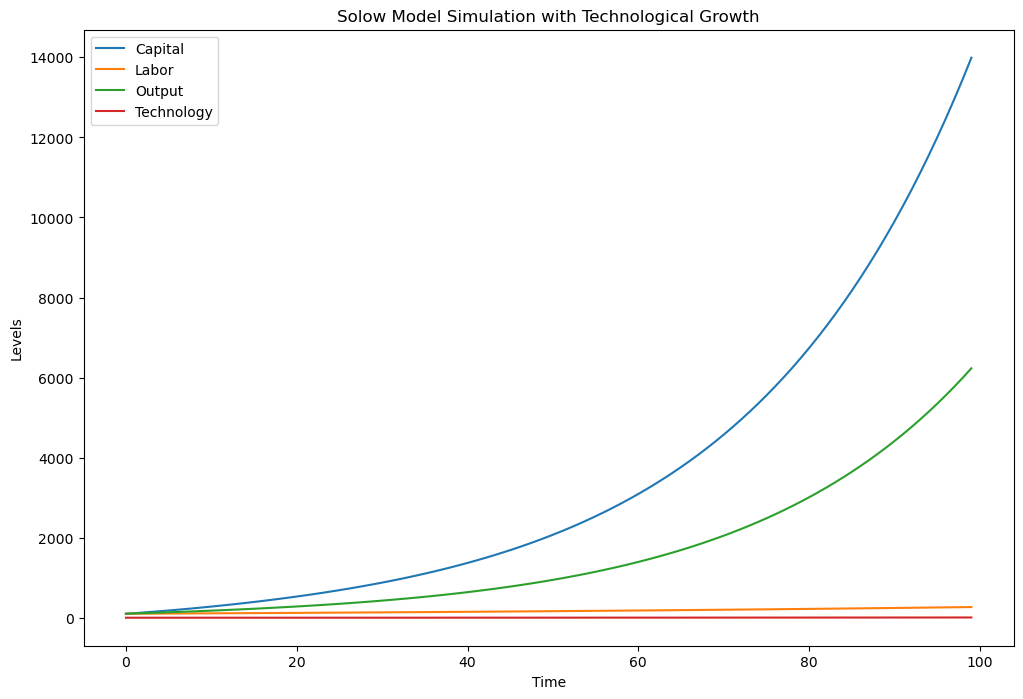

In [49]:

# Parameters
s = 0.2       # Savings rate
alpha = 0.3   # Output elasticity of capital
delta = 0.05  # Depreciation rate
n = 0.01      # Population growth rate
g = 0.02      # Technological growth rate
K0 = 100      # Initial capital stock
L0 = 100      # Initial labor
T = 100       # Number of time periods to simulate

# Initialize arrays to store the time series of capital, labor, and output
K = np.zeros(T)
L = np.zeros(T)
Y_base = np.zeros(T)
A = np.zeros(T)
K[0] = K0
L[0] = L0
A[0] = 1

# Simulation
for t in range(T-1):
    Y_base[t] = A[t] * K[t]**alpha * L[t]**(1-alpha)  # Production function with technology
    K[t+1] = s * Y_base[t] + (1 - delta) * K[t]  # Capital accumulation
    L[t+1] = (1 + n) * L[t]  # Population growth
    A[t+1] = (1 + g) * A[t]  # Technological growth

# Output in the last period
Y_base[T-1] = A[T-1] * K[T-1]**alpha * L[T-1]**(1-alpha)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(K, label='Capital')
plt.plot(L, label='Labor')
plt.plot(Y_base, label='Output')
plt.plot(A, label='Technology')
plt.title('Solow Model Simulation with Technological Growth')
plt.xlabel('Time')
plt.ylabel('Levels')
plt.legend()
plt.show()

# MANGLER TEKST

Now we will go to the numerical solution. We will here find the steady state solution for capital per capita using a root solver.

In [50]:
import numpy as np
from scipy.optimize import root_scalar

# Parameters
s = 0.2       # Savings rate
alpha = 0.3   # Output elasticity of capital
delta = 0.05  # Depreciation rate
n = 0.01      # Population growth rate
g = 0.02      # Technological growth rate

# Defining the steady state function explicitly to prevent negative values of k
def steady_state_k_scalar(k):
    if k <= 0:
        return float('inf')  # Return a large number to avoid negative or zero capital computations
    else:
        return k - (s * k**alpha) / (delta + n + g)

# Solving using root_scalar with bracket method, providing a range where the root is expected
result = root_scalar(steady_state_k_scalar, bracket=[0.1, 100], method='brentq')
k_star = result.root

print("Steady state capital per capita (k^*):", format(k_star, ".10f"))

Steady state capital per capita (k^*): 3.7024203699


# Solow Model with technological growth and human capital

We further extend the model by implementing human capital as well as technological growth. We keep the growth rate of technology at 2%. We set the average human capital level $(h)$ per worker at 1.2. More about this later.

The extended Solow Model now has the following equations:

1. **Production Function**:
   $Y_t = K_t^\alpha (A_t H_t)^{1-\alpha}$
   where:
   - $Y_t$ is output at time $t$.
   - $A_t$ is level of technology at time $t$.
   - $K_t$ is the capital stock at time t $t$.
   - $H_t$ is the human capital stock at time $t$.
   - $L_t$ is the labor force at time $t$.
   - $\alpha$ is the output elasticity of capital, $0 < \alpha < 1$.

2. **Technological Growth**:
   $A_{t+1} = (1 + g)A_t$
   where:
   - $g$ is the growth rate of technology.

3. **Human Capital**:
   $H_t = h L_t$
   where:
   - $h$ is the average human capital level per worker.

The extended model takes both technological growth and human capital's role into account for productivity improvements whuch gives a more nuanced understanding of economic growth.

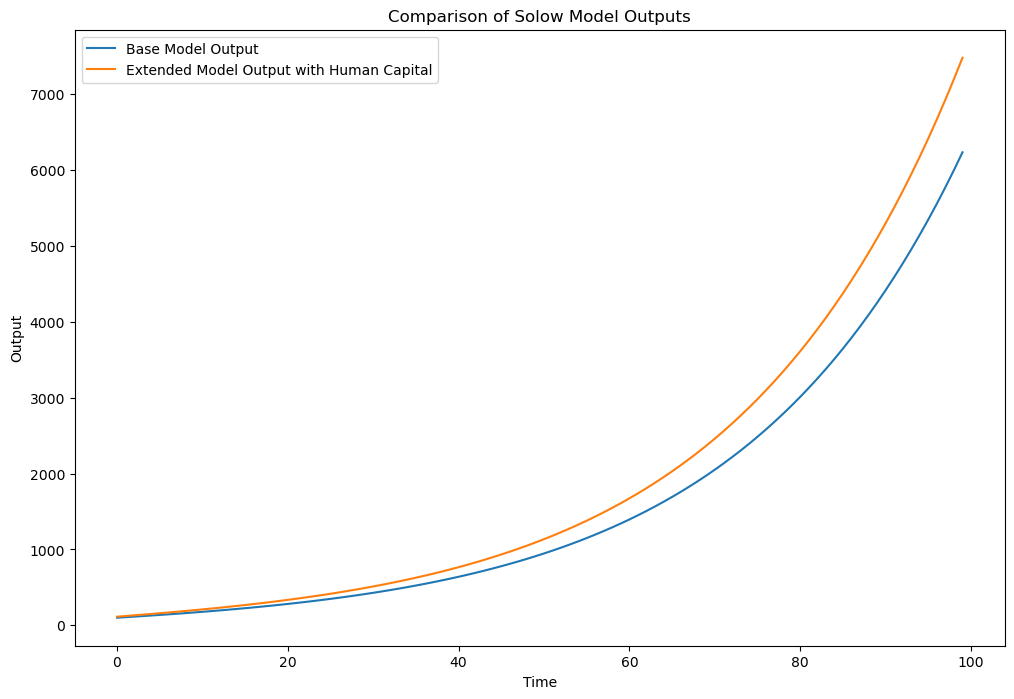

In [51]:
# Parameters for the extended model
h = 1.2  # Average level of human capital

# Initialize arrays to store the time series of human capital and extended output
H = np.zeros(T)
Y_ext = np.zeros(T)
H[0] = h * L[0]

# Simulation with human capital and technology
for t in range(T-1):
    Y_ext[t] = A[t] * K[t]**alpha * (H[t])**(1-alpha)  # Production function with human capital and technology
    K[t+1] = s * Y_ext[t] + (1 - delta) * K[t]  # Capital accumulation
    L[t+1] = (1 + n) * L[t]  # Population growth
    A[t+1] = (1 + g) * A[t]  # Technological growth
    H[t+1] = h * L[t+1]  # Human capital growth

# Output in the last period
Y_ext[T-1] = A[T-1] * K[T-1]**alpha * (H[T-1])**(1-alpha)

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(Y_base, label='Base Model Output')
plt.plot(Y_ext, label='Extended Model Output with Human Capital')
plt.title('Comparison of Solow Model Outputs')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.show()

Now, we'll embark on finding the steady state for the Solow model under the two scenarios: with only technological growth and with both technological growth and human capital. The steady state represents an equilibrium point where key economic variables stabilize over time. By analyzing these scenarios, we aim to understand how both technological progress and human capital influences the long-term economic equilibrium predicted by the Solow model.

In [52]:
def find_per_capita_steady_state(s, alpha, delta, n, g=None, h=None):
    """
    Find steady state for the two versions of the Solow Model in per capita terms.
    
    Parameters:
        s (float): savings rate
        alpha (float): output elasticity of capital
        delta (float): depreciation rate
        n (float): population growth rate
        g (float, valgfri): technological growth rate, if None, it solves the model without it
        h (float, valgfri): average level of human capital, if None, it solves the model without it
    
    Returns:
        k_star (float): steady state level of capital per capita
    """
    if g is None:  # Solow model without technological growth
        growth_rate = n + delta
    else:  # Solow model with technological growth
        growth_rate = n + g + delta
    
    if h is None: # Solow model without human capital
        k_star = (s / growth_rate) ** (1 / (1 - alpha))
    else: # Extended Solow model with human capital
        k_star = (s * h**(1 - alpha) / growth_rate) ** (1 / (1 - alpha))
    
    return k_star

# Parameters
s = 0.20       # Savings rate
alpha = 0.30   # Output elasticity of capital
delta = 0.05   # Depreciation rate
n = 0.01       # Population growth rate
g = 0.02       # Technological growth rate
h = 1.2        # Average level of human capital

# Find steady state capital per capita for both models
k_star_tech_growth = find_per_capita_steady_state(s, alpha, delta, n, g)
k_star_extended = find_per_capita_steady_state(s, alpha, delta, n, g, h)

print("Steady State Capital per capita (Solow with Technological Growth):", k_star_tech_growth)
print("Steady State Capital per efficiency unit (Extended Solow with Human Capital):", k_star_extended)

Steady State Capital per capita (Solow with Technological Growth): 3.7024203699314673
Steady State Capital per efficiency unit (Extended Solow with Human Capital): 4.442904443917761


Showing steady state for solow model with technological growth and the solow model with techonological growth and human capital in a transition diagram:

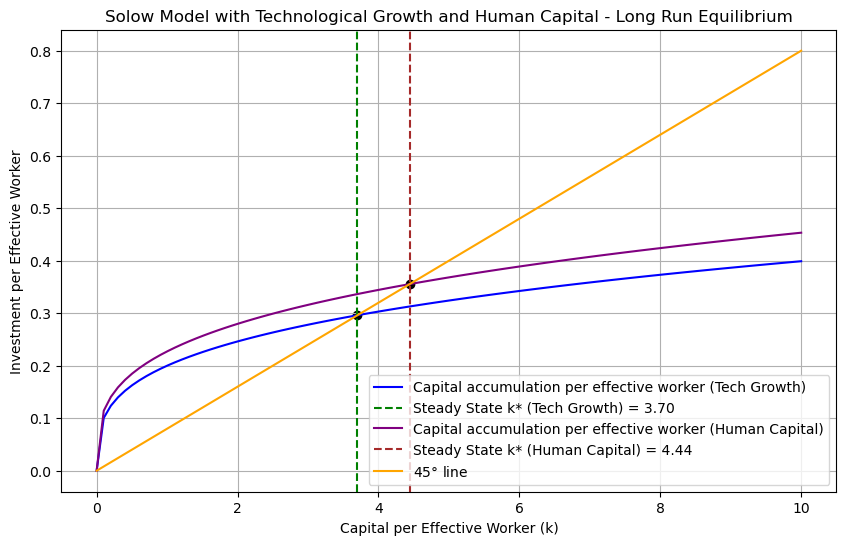

In [56]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters for Technological Growth
s_tech = 0.2       # Savings rate
alpha_tech = 0.3   # Output elasticity of capital
delta_tech = 0.05  # Depreciation rate
n_tech = 0.01      # Population growth rate
g_tech = 0.02      # Technological growth rate


# Parameters for Human Capital
s_hum = 0.2      # Savings rate
alpha_hum = 0.3   # Output elasticity of capital
delta_hum = 0.05   # Depreciation rate
n_hum = 0.01       # Population growth rate
g_hum = 0.02       # Technological growth rate
h_hum = 1.2        # Average human capital per worker


# Capital per effective worker (k)
k = np.linspace(0, 10, 100)


# Output per effective worker (y) for Technological Growth
y_tech = k ** alpha_tech


# Investment per effective worker (i) for Technological Growth
i_tech = s_tech * y_tech


# Depreciation line for Technological Growth
dep_tech = (n_tech + g_tech + delta_tech) * k


# Steady state k* for Technological Growth
k_star_tech = (s_tech / (n_tech + g_tech + delta_tech)) ** (1 / (1 - alpha_tech))


# Output per effective worker (y) for Human Capital
y_hum = (k ** alpha_hum) * (h_hum ** (1 - alpha_hum))


# Investment per effective worker (i) for Human Capital
i_hum = s_hum * y_hum


# Depreciation line for Human Capital
dep_hum = (n_hum + g_hum + delta_hum) * k


# Steady state k* for Human Capital
k_star_hum = ((s_hum * (h_hum ** (1 - alpha_hum))) / (n_hum + g_hum + delta_hum)) ** (1 / (1 - alpha_hum))


# Plotting the diagram
plt.figure(figsize=(10, 6))


# Plot for Technological Growth
plt.plot(k, i_tech, label='Capital accumulation per effective worker (Tech Growth)', color='blue')
plt.axvline(x=k_star_tech, color='green', linestyle='--', label=f'Steady State k* (Tech Growth) = {k_star_tech:.2f}')
plt.scatter([k_star_tech], [s_tech * (k_star_tech ** alpha_tech)], color='black')  # Steady state point (Tech Growth)


# Plot for Human Capital
plt.plot(k, i_hum, label='Capital accumulation per effective worker (Human Capital)', color='purple')
plt.axvline(x=k_star_hum, color='brown', linestyle='--', label=f'Steady State k* (Human Capital) = {k_star_hum:.2f}')
plt.scatter([k_star_hum], [s_hum * (k_star_hum ** alpha_hum) * (h_hum ** (1 - alpha_hum))], color='black')  # Steady state point (Human Capital)
plt.plot(k, dep_hum, label='45$\degree$ line', color='orange')


# Titles and labels
plt.title('Solow Model with Technological Growth and Human Capital - Long Run Equilibrium')
plt.xlabel('Capital per Effective Worker (k)')
plt.ylabel('Investment per Effective Worker')
plt.legend()
plt.grid(True)
plt.show()

The diagram shows the long-run equilibrium in the Solow model with both technological growth and human capital. The different curves represent capital accumulation per effective worker and the investment level required to maintain steady state for both technological growth and human capital.

**Explanation of the Curves:**

**- Capital Accumulation per Effective Worker (Technological Growth) (blue curve):** This curve shows how capital per effective worker accumulates over time with technological growth.

**- Capital Accumulation per Effective Worker (Human Capital) (purple curve):** This curve shows capital accumulation per effective worker when human capital is also considered, further enhancing productivity compared to just technological growth.

**- Steady State $k^∗_t$ (Technological Growth) (green dashed line):** The green vertical line marks the steady state level of capital per effective worker when only technological growth is included. In this case, the steady state capital level is $k^∗$ = 3.70

**- Steady State $k^*_h$ (Human Capital) (red dashed line):** The red vertical line marks the steady state level of capital per effective worker when both technological growth and human capital are included. Here, the steady state capital level is $k^∗$ = 4.44 which is higher than in the case with only technological growth.

**45° line (orange curve):** This line represents the situation where investments exactly match capital accumulation, i.e., when the economy is in steady state.

**Key Observations:**

**- Increased Steady State Level with Human Capital:** Incorporating human capital increases the steady state level of capital per effective worker from 3.70 to 4.44. This indicates that the economy can achieve a higher capital stock and thus higher output when education and skills in the workforce improve.

**- Enhanced Productivity:** The purple curve for capital accumulation per effective worker (with human capital) lies above the blue curve (only technological growth), showing that the addition of human capital increases overall productivity and thus capital accumulation.

This diagram demonstrates how extending the Solow model to include both technological growth and human capital can lead to a higher steady state capital per effective worker and thus a more robust and sustainable economic growth.

# Conclusion: Impact of human capital on solow model with technological growth


Including human capital in a Solow model with technological growth leads to a higher steady state of capital per effective worker, as seen by the intersection of the purple curve (4.44) compared to the blue curve (3.70).

Overall we can conclude that the extension with human capital raises the steady state capital from 3.70 to 4.44, indicating higher capital per effective worker. Also human capital enhances the productivity of both labor and capital, resulting in greater capital accumulation.


Looking at the long run the addition of human capital results in a more sustainable growth path and higher living standards.


Integrating human capital into the Solow model with technological growth leads to a higher steady state and improved economic growth, highlighting the importance of investing in education and skills for a sustainable economy.
